In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
games = pd.read_csv('games_data_raw.csv')
usernames = pd.read_csv('usernames.csv')

# Raw Data Overview

In [3]:
games.head()

,Username (White),Rating (White),Title (White),Username (Black),Rating (Black),Title (Black),Result,Accuracy,Moves Count,Date,Time Control,Tournament Game
0,MagnusCarlsen,(3306),GM,GMWSO,(3129),GM,½½,96 96.1,49,"Sep 19, 2023",1|1,N
1,GMWSO,(3125),GM,MagnusCarlsen,(3310),GM,½½,94.5 94.2,48,"Sep 19, 2023",1|1,N
2,MagnusCarlsen,(3314),GM,GMWSO,(3121),GM,01,76 86.7,36,"Sep 19, 2023",1|1,N
3,GMWSO,(3109),GM,MagnusCarlsen,(3326),GM,½½,98.5 99.2,33,"Sep 19, 2023",1|1,N
4,MagnusCarlsen,(3331),GM,GMWSO,(3104),GM,10,88.7 75,18,"Sep 19, 2023",1|1,N


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20250 entries, 0 to 20249
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Username (White)  20250 non-null  object
 1   Rating (White)    20250 non-null  object
 2   Title (White)     18751 non-null  object
 3   Username (Black)  20250 non-null  object
 4   Rating (Black)    20250 non-null  object
 5   Title (Black)     18748 non-null  object
 6   Result            20250 non-null  object
 7   Accuracy          20205 non-null  object
 8   Moves Count       20250 non-null  int64 
 9   Date              20250 non-null  object
 10  Time Control      20250 non-null  object
 11  Tournament Game   20250 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.9+ MB


# Data Cleaning and Feature Engineering

In [5]:
#Remove any duplicates
games.drop_duplicates(inplace=True)

## Result

In [6]:
#Change data type to category and add order ( ordinal data ; White Win > Draw > Black Win ( White Lose ) )
games["Result"] = games["Result"].astype('category');
games["Result"] = games["Result"].cat.rename_categories( {'10': 'White Win' , '½½' : 'Draw' , '01': 'Black Win' } );
games["Result"].cat.reorder_categories(['White Win' , 'Draw' , 'Black Win']);

## Rating & Rating Difference

In [7]:
#Remove Parenthesis and change to int data type
games["Rating (White)"] = games["Rating (White)"].apply( lambda x: int(x.strip('(').strip(')')));
games["Rating (Black)"] = games["Rating (Black)"].apply( lambda x: int(x.strip('(').strip(')')));

#Calculate Difference in Rating between each player
games['Rating Difference'] = games["Rating (White)"] - games["Rating (Black)"]

## Title 

In [8]:
# Change to categorical data type
# Simplify Titles based on minimum rating required to gain title and create ordinal data 
# Low number of observations for NM, WIM, CM, WFM and WCM - group together as NM to reduce dimensionality and increase observations for this category

# Each title has a minimum rating required to achieve the title. To reduce dimensionality, merge FM and WGM as both have minimum rating of 2300
# Similaryly, merge NM, WIM, CM as all have minimum rating of 2200 
# WFM and WCM have minimum rating of 2100 and 2000 respectively. There are low number of observations for each, hence merge with NM,WIM and CM.
# This will avoid estimation errors later by avoiding high dimensionality and low observation counts
games["Title (White)"].value_counts()

Title (White)
GM     11996
IM      1876
FM      1866
NM       649
CM       379
WFM       53
WGM       27
WIM       14
WCM       10
Name: count, dtype: int64

In [9]:
# Aggregate titles to simplified categories
games["Title (White)"].replace(to_replace= {'WGM': 'FM' , 'WIM':'NM','CM':'NM','WFM':'NM','WCM':'NM'} , inplace=True)
games["Title (Black)"].replace(to_replace= {'WGM': 'FM' , 'WIM':'NM','CM':'NM','WFM':'NM','WCM':'NM'} , inplace=True)

#Fill NA values with 'No Title'
games['Title (White)'].fillna(value='No Title' , inplace=True)
games['Title (Black)'].fillna(value='No Title' , inplace=True)

#Change to categorical data and add ordinality 
games['Title (White)'] = pd.Categorical(values = games['Title (White)'] , categories=['No Title','NM','FM','IM','GM'] , ordered = True)
games['Title (Black)'] = pd.Categorical(values = games['Title (Black)'] , categories=['No Title','NM','FM','IM','GM'] , ordered = True)

#Verify
games["Title (White)"].value_counts()

Title (White)
GM          11996
FM           1893
IM           1876
No Title     1492
NM           1105
Name: count, dtype: int64

## Accuracy & Accuracy Difference

In [10]:
#Accuracy
#Create two new columns for Accuracy of White and Black player by splitting datapoints on whitespace between accuracy values
#Change 'Review' inputs in each column to None
#Change type of data to float type
#Drop original Accuracy Column

games["Accuracy (White)"] = games["Accuracy"].apply(lambda x: str(x).split(' ')[0]);
games["Accuracy (Black)"] = games["Accuracy"].apply(lambda x: str(x).split(' ')[-1]); # Note -1 value here duplicates 'Review' values in case that accuracy is not available 

games["Accuracy (White)"].replace(to_replace="Review" , value= np.nan , inplace=True)
games["Accuracy (Black)"].replace(to_replace="Review" , value= np.nan , inplace=True)

games["Accuracy (White)"] = games["Accuracy (White)"].astype('float')
games["Accuracy (Black)"] = games["Accuracy (Black)"].astype('float')

games.drop('Accuracy' , axis = 1 , inplace=True)

#Calculate Difference in Accuracy between each player
games['Accuracy Difference'] = games["Accuracy (White)"] - games["Accuracy (Black)"]

## Moves Count

In [11]:
#Change to int type
games["Moves Count"] = games["Moves Count"].astype('int')

## Time Control - Time,Increment & Total Time

In [12]:
#Create starting time and Increment columns from Time Control
#'Time' is the time each player has on their clock at the start of the game and 
#'Increment' is the amount of time that is added to their clock after each mode made 
#If time controls contains '|', then there is an increment, else it is 0 ie. no time added on

#Extract Time from Time Control 
games['Time'] = games['Time Control'].apply(lambda x: x.split("|")[0])

#Define function to clean time data
#Remove strings 'min' and 'sec'
#Change data to minutes as standard
def games_time_clean(s):
    if "sec" in s:
        s = s.strip('sec').replace(' ','')
        s = np.divide(float(s) , 60 )
    elif "min" in s:
        s = s.strip('min').replace(' ','')
    return float(s)

games['Time'] = games['Time'].apply(func = games_time_clean)

#Extract Interval from Time Control and clean data
#Interval is defined in seconds
games['Interval'] = games['Time Control'].where( games['Time Control'].str.contains("|" , regex = False) )
games['Interval'].fillna("0" , inplace = True)
games['Interval'] = games['Interval'].apply(lambda x: x.split("|")[-1])
games['Interval'] = games['Interval'].astype('float')

#Remove Time Control column
games.drop('Time Control' , axis = 1 , inplace = True)

# Add total time variable as below
games['Total Time'] = games['Time'] + games['Interval']*games['Moves Count']/60

#Add Game Type column as ordered category
games['Game Type'] = "Rapid" #games longer than 10 mins are 'Rapid' games
games['Game Type'].where(games['Time'] >= 10 , "Blitz" , inplace=True) #games 3 mins or more and less than 10 mins are 'Blitz' games
games['Game Type'].where(games['Time'] >= 3 , "Bullet" , inplace=True) #games under 3 mins are 'Bullet' games
games['Game Type'] = pd.Categorical( values = games['Game Type'] , categories = ['Bullet' , 'Blitz' , 'Rapid'], ordered = True)

## Tournament Game

In [13]:
#Change Data type to Category
games['Tournament Game'] = games['Tournament Game'].astype('category')

# Outliers and Further Cleaning

In [14]:
# Some very low ratings - likely contributes to large rating differences - consider removing large rating difference games as outliers - Check
# 0 Move games - remove as invalid games, consider removing games with < x games, with x to be decided upon closer inspection - Check
# 0 accuracy games - investigate and remove outliers - Check

games.describe()

,Rating (White),Rating (Black),Moves Count,Rating Difference,Accuracy (White),Accuracy (Black),Accuracy Difference,Time,Interval,Total Time
count,18362.000000,18362.000000,18362.000000,18362.000000,10939.000000,10939.000000,10939.000000,18362.000000,18362.000000,18362.000000
mean,2858.907200,2857.895273,44.452129,1.011927,85.011427,84.107505,0.903922,3.121236,0.503377,3.502851
std,274.324568,269.446871,18.940349,306.993230,9.007131,9.375124,8.861850,3.575101,1.620398,4.413981
min,310.000000,149.000000,0.000000,-2623.000000,0.000000,0.000000,-65.400000,0.166667,0.000000,0.166667
25%,2740.000000,2735.000000,31.000000,-117.000000,80.300000,79.400000,-5.500000,1.000000,0.000000,1.000000
50%,2925.500000,2923.500000,42.000000,2.000000,85.900000,84.900000,0.200000,3.000000,0.000000,3.000000
75%,3029.000000,3028.000000,56.000000,124.000000,91.200000,90.300000,6.900000,3.000000,1.000000,3.633333
max,3364.000000,3364.000000,204.000000,2911.000000,100.000000,100.000000,100.000000,90.000000,60.000000,110.000000


In [15]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18362 entries, 0 to 20249
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Username (White)     18362 non-null  object  
 1   Rating (White)       18362 non-null  int64   
 2   Title (White)        18362 non-null  category
 3   Username (Black)     18362 non-null  object  
 4   Rating (Black)       18362 non-null  int64   
 5   Title (Black)        18362 non-null  category
 6   Result               18362 non-null  category
 7   Moves Count          18362 non-null  int32   
 8   Date                 18362 non-null  object  
 9   Tournament Game      18362 non-null  category
 10  Rating Difference    18362 non-null  int64   
 11  Accuracy (White)     10939 non-null  float64 
 12  Accuracy (Black)     10939 non-null  float64 
 13  Accuracy Difference  10939 non-null  float64 
 14  Time                 18362 non-null  float64 
 15  Interval             183

## Accuracy and Moves Count

In [16]:
# 0 accuracy games - investigate and remove outlier
# After inspecting, I realised that these 0 values are errors on the part of Chess.com ~ games have non zero accuracy values but are displayed as 0
# All other data is correct, change 0 values to None values instead
games[((games['Accuracy (Black)'] == 0 ) | (games['Accuracy (White)'] == 0))].head()

,Username (White),Rating (White),Title (White),Username (Black),Rating (Black),Title (Black),Result,Moves Count,Date,Tournament Game,Rating Difference,Accuracy (White),Accuracy (Black),Accuracy Difference,Time,Interval,Total Time,Game Type
184,viditchess,3076,GM,MagnusCarlsen,3250,GM,Draw,84,"Sep 12, 2023",N,-174,0.0,0.0,0.0,5.0,1.0,6.400000,Blitz
302,Hikaru,3329,GM,Gogolev_Artemy,2453,IM,White Win,1,"Sep 16, 2023",Y,876,100.0,0.0,100.0,1.0,0.0,1.000000,Bullet
669,viditchess,3047,GM,Kacparov,2940,IM,Draw,48,"Aug 21, 2023",Y,107,0.0,0.0,0.0,3.0,1.0,3.800000,Blitz
755,viditchess,3026,GM,Gabrielian_Artur,2817,GM,White Win,34,"Mar 28, 2023",Y,209,0.0,0.0,0.0,3.0,1.0,3.566667,Blitz
1167,lachesisQ,2778,GM,Bigfish1995,2753,GM,White Win,58,"Aug 31, 2023",N,25,0.0,0.0,0.0,15.0,3.0,17.900000,Rapid


In [17]:
# 0 Move games - remove as invalid games, consider removing games with < x games, with x to be decided upon closer inspection 
# For rated games to be counted as rated, at least four moves have to be made by one player (i.e. in normal games white has to have made his fourth move). If the game is a tournament game or a team match game, it will be counted as rated even if it has less moves than that.
games.drop(games[games['Moves Count'] < 4].index , axis=0 , inplace=True)

#no games with non zero accuracy have other column with zero accuracy - recalculate Accuracy Difference to avoid invalid 0 values
games["Accuracy (White)"].replace(to_replace= 0 , value= np.nan, inplace=True)
games["Accuracy (Black)"].replace(to_replace= 0 , value= np.nan, inplace=True)
games['Accuracy Difference'] = games["Accuracy (White)"] - games["Accuracy (Black)"]

In [18]:
#Games with 100% accuracy from both players
#Not considered valid, this relates to players who play a small number of moves ( opening moves ) and agree to draw where a draw is sufficient for both players to continue in a tournament
#Note one game here is a win for Black, in this case the white player is much lower rated than the black player and resigns after 4 moves ( ie. does not play )
#Drop these games from the dataset
games[(games["Accuracy (White)"] == 100) & (games["Accuracy (Black)"] == 100) ].head()

,Username (White),Rating (White),Title (White),Username (Black),Rating (Black),Title (Black),Result,Moves Count,Date,Tournament Game,Rating Difference,Accuracy (White),Accuracy (Black),Accuracy Difference,Time,Interval,Total Time,Game Type
272,FabianoCaruana,2828,GM,Hikaru,2802,GM,Draw,7,"Sep 18, 2023",Y,26,100.0,100.0,0.0,10.0,2.0,10.233333,Rapid
273,Hikaru,2801,GM,FairChess_on_YouTube,2713,GM,Draw,4,"Sep 18, 2023",Y,88,100.0,100.0,0.0,10.0,2.0,10.133333,Rapid
1175,lachesisQ,2762,GM,Firouzja2003,2755,GM,Draw,14,"Jul 24, 2023",Y,7,100.0,100.0,0.0,10.0,2.0,10.466667,Rapid
1179,Igrok3069,2673,GM,lachesisQ,2750,GM,Draw,9,"Jul 24, 2023",Y,-77,100.0,100.0,0.0,10.0,2.0,10.300000,Rapid
1425,LyonBeast,2759,GM,FairChess_on_YouTube,2714,GM,Draw,4,"Sep 18, 2023",Y,45,100.0,100.0,0.0,10.0,2.0,10.133333,Rapid


In [19]:
games.drop(games[(games["Accuracy (White)"] == 100) & (games["Accuracy (Black)"] == 100)].index , inplace=True)

## Rating & Titles - No titles remove

In [20]:
# No title players appear to be introducing large outliers in rating difference 
# Lower rated players in the context of our analysis are outliers and chose to remove these games
games.drop(games[(games['Title (White)'] =='No Title') | (games['Title (Black)'] == 'No Title')].index , axis=0 , inplace=True)

,Username (White),Rating (White),Title (White),Username (Black),Rating (Black),Title (Black),Result,Moves Count,Date,Tournament Game,Rating Difference,Accuracy (White),Accuracy (Black),Accuracy Difference,Time,Interval,Total Time,Game Type
74,latigre,1593,NM,MagnusCarlsen,3317,GM,Black Win,38,"Sep 16, 2023",Y,-1724,75.6,83.7,-8.1,1.0,0.0,1.0,Bullet
298,Hikaru,3331,GM,Nasrin_Babayeva,1770,NM,White Win,11,"Sep 16, 2023",Y,1561,89.3,77.0,12.3,1.0,0.0,1.0,Bullet
337,latigre,1570,NM,Hikaru,3304,GM,Black Win,22,"Sep 16, 2023",Y,-1734,69.7,82.0,-12.3,1.0,0.0,1.0,Bullet
349,Nasrin_Babayeva,1648,NM,Hikaru,3312,GM,Black Win,41,"Sep 16, 2023",Y,-1664,79.9,92.8,-12.9,1.0,0.0,1.0,Bullet
4422,Oleksandr_Bortnyk,3167,GM,latigre,1595,NM,White Win,15,"Sep 16, 2023",Y,1572,NaN,NaN,NaN,1.0,0.0,1.0,Bullet
4424,latigre,1595,NM,Oleksandr_Bortnyk,3160,GM,Black Win,47,"Sep 16, 2023",Y,-1565,NaN,NaN,NaN,1.0,0.0,1.0,Bullet
4783,Synctel,1646,NM,FEKKET-ESZTER,2722,FM,Black Win,35,"Jul 15, 2023",Y,-1076,NaN,NaN,NaN,1.0,0.0,1.0,Bullet
7885,Grischuk,3027,GM,shirovin,1687,NM,White Win,17,"Jul 7, 2023",Y,1340,89.3,70.8,18.5,1.0,0.0,1.0,Bullet
10562,Zhigalko_Sergei,3086,GM,latigre,1570,NM,White Win,19,"Sep 16, 2023",Y,1516,NaN,NaN,NaN,1.0,0.0,1.0,Bullet
11495,LastGladiator1,3044,GM,shirovin,1597,NM,White Win,15,"Jul 6, 2023",Y,1447,NaN,NaN,NaN,1.0,0.0,1.0,Bullet


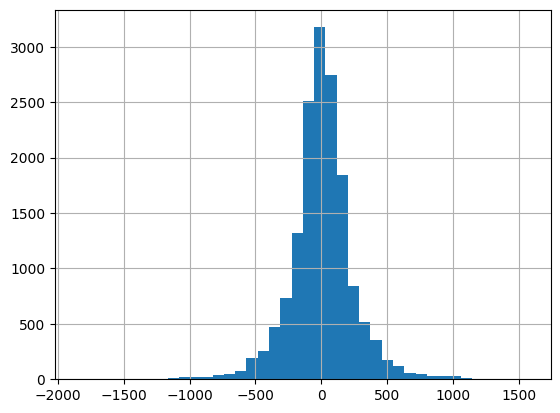

In [21]:
# Some very low ratings - likely contributes to large rating differences - consider removing large rating difference games as outliers
games['Rating Difference'].hist( bins = 40)
games[(games['Rating (White)'] < 1800) | (games['Rating (Black)'] < 1800)]

In [22]:
#After checking some of the above ratings vs current ratings, we can conclude that the only abnormal values are that of 'PursuitOfHappyness2', who is currently over 2400+ and was much higher rated in reality than these games suggest
#Remove these outliers
games.drop([18887 , 18888] , inplace=True)

# Cleaned Data Overview and Write to CSV

In [23]:
games.head()

,Username (White),Rating (White),Title (White),Username (Black),Rating (Black),Title (Black),Result,Moves Count,Date,Tournament Game,Rating Difference,Accuracy (White),Accuracy (Black),Accuracy Difference,Time,Interval,Total Time,Game Type
0,MagnusCarlsen,3306,GM,GMWSO,3129,GM,Draw,49,"Sep 19, 2023",N,177,96.0,96.1,-0.1,1.0,1.0,1.816667,Bullet
1,GMWSO,3125,GM,MagnusCarlsen,3310,GM,Draw,48,"Sep 19, 2023",N,-185,94.5,94.2,0.3,1.0,1.0,1.800000,Bullet
2,MagnusCarlsen,3314,GM,GMWSO,3121,GM,Black Win,36,"Sep 19, 2023",N,193,76.0,86.7,-10.7,1.0,1.0,1.600000,Bullet
3,GMWSO,3109,GM,MagnusCarlsen,3326,GM,Draw,33,"Sep 19, 2023",N,-217,98.5,99.2,-0.7,1.0,1.0,1.550000,Bullet
4,MagnusCarlsen,3331,GM,GMWSO,3104,GM,White Win,18,"Sep 19, 2023",N,227,88.7,75.0,13.7,1.0,1.0,1.300000,Bullet


In [24]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15706 entries, 0 to 20249
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Username (White)     15706 non-null  object  
 1   Rating (White)       15706 non-null  int64   
 2   Title (White)        15706 non-null  category
 3   Username (Black)     15706 non-null  object  
 4   Rating (Black)       15706 non-null  int64   
 5   Title (Black)        15706 non-null  category
 6   Result               15706 non-null  category
 7   Moves Count          15706 non-null  int32   
 8   Date                 15706 non-null  object  
 9   Tournament Game      15706 non-null  category
 10  Rating Difference    15706 non-null  int64   
 11  Accuracy (White)     10006 non-null  float64 
 12  Accuracy (Black)     10006 non-null  float64 
 13  Accuracy Difference  10006 non-null  float64 
 14  Time                 15706 non-null  float64 
 15  Interval             157

In [25]:
games.to_csv('games_data_clean.csv', index = False)

### Archive

#### Ratings & Titles - GM games only

In [125]:
# For the purpose of this analysis, we will restrict games to 'GM' players
games.drop(games[(games['Title (White)'] !='GM') | (games['Title (Black)'] != 'GM')].index , axis=0 , inplace=True)

,Username (White),Rating (White),Title (White),Username (Black),Rating (Black),Title (Black),Result,Moves Count,Date,Tournament Game,Rating Difference,Accuracy (White),Accuracy (Black),Accuracy Difference,Time,Interval,Total Time,Game Type
262,Hikaru,3239,GM,tetrix83,2603,GM,White Win,47,"Sep 19, 2023",Y,636,92.0,86.6,5.4,3.0,1.0,3.783333,Blitz
371,Hikaru,3295,GM,VitaliyBernadskiy,2675,GM,White Win,12,"Sep 16, 2023",Y,620,97.2,79.3,17.9,1.0,0.0,1.000000,Bullet
5633,Indianlad,2976,GM,CheckBits,2211,GM,White Win,35,"Aug 26, 2023",Y,765,NaN,NaN,NaN,1.0,0.0,1.000000,Bullet
9215,Jospem,3153,GM,gm_rashid,2303,GM,White Win,12,"Sep 16, 2023",Y,850,NaN,NaN,NaN,1.0,0.0,1.000000,Bullet
9281,Jospem,3148,GM,theredking89,2513,GM,White Win,30,"Sep 16, 2023",N,635,NaN,NaN,NaN,1.0,0.0,1.000000,Bullet
9282,theredking89,2515,GM,Jospem,3148,GM,White Win,29,"Sep 16, 2023",N,-633,85.5,75.4,10.1,1.0,0.0,1.000000,Bullet
9283,Jospem,3164,GM,theredking89,2451,GM,White Win,54,"Sep 16, 2023",N,713,89.1,88.6,0.5,1.0,0.0,1.000000,Bullet
9284,theredking89,2452,GM,Jospem,3164,GM,Black Win,46,"Sep 16, 2023",N,-712,NaN,NaN,NaN,1.0,0.0,1.000000,Bullet
9285,Jospem,3164,GM,theredking89,2453,GM,White Win,44,"Sep 16, 2023",N,711,NaN,NaN,NaN,1.0,0.0,1.000000,Bullet
9286,theredking89,2454,GM,Jospem,3164,GM,Black Win,58,"Sep 16, 2023",N,-710,NaN,NaN,NaN,1.0,0.0,1.000000,Bullet


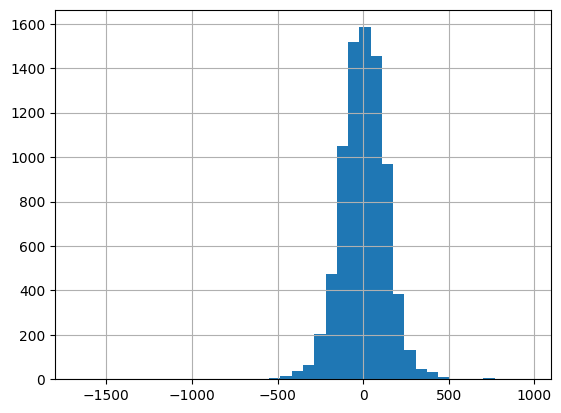

In [126]:
# Some very low ratings - likely contributes to large rating differences - consider removing large rating difference games as outliers
games['Rating Difference'].hist( bins = 40)
games[abs(games['Rating Difference']) > 600]

In [127]:
#After checking some of the above ratings vs current ratings, we can conclude that the only abnormal values are that of 'PursuitOfHappyness2', who is currently over 2400+ and was much higher rated in reality than these games suggest
#Remove these outliers
games.drop([18887 , 18888] , inplace=True)